In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import datetime as dt
import numpy as np
import plotly.express as px
import warnings
from matplotlib import rcParams
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage


pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-white')
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# **Описание данных**

**Данные клиента за предыдущий до проверки факта оттока месяц:**
`gender` — пол;

`Near_Location` — проживание или работа в районе, где находится фитнес-центр;

`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

`Phone` — наличие контактного телефона;

`Age` — возраст;

`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
 
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);

`Group_visits` — факт посещения групповых занятий;

`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;

`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;

`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

`Churn` — факт оттока в текущем месяце.

In [2]:
try:
    df = (
    pd.read_csv('D:/datasets/gym_churn.csv') 
)
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

# **Проведем исследовательский анализ данных (EDA)**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.columns = df.columns.str.lower()
df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


- Дубликатов нет

In [5]:
df.duplicated().sum()

0

- Заменим значения некоторых данных с int64 на bool, значения Month_to_end_contract на целочисленное

In [6]:
df[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].astype('bool')
df['month_to_end_contract'].astype('int64')
/

()

- Значение пола распределено примерно одинаково


- Клиенты в большей степени выбирают спортзал поблизости 


- Почти половина пользователей - клиенты-партнеры фитнес клуба


- По промоакции пришло `31% клиентов`


- Средняя длина абонемента в зале составляет `5 месяцев`


- Средний возраст `29 лет`


- Средняя выручка от других услуг фитнес-центра составляет `147`


- Срок до окончания текущего действующего абонемента - `4 месяца`


- Время с момента первого обращения в фитнес-центр - `3.7 месяца`


- Средняя частота посещений в неделю за все время с начала действия абонемента - `1.8 раз`


- Средняя частота посещений в неделю за предыдущий месяц - `1.7 раз`.


- Факт оттока в текущем месяце `27%`

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.00,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.00,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.00,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.00,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.00,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.00,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.00,4.32,4.19,1.00,1.00,1.00,6.00,12.00


**Проверим средние значения групп - `Отток` и `Оставшиеся`**

- Значение пола распределено одинаково


- Клиенты, проживающие близко к спортзалу реже привержены к оттоку


- Клиенты-партнеры фитнес клуба реже привержены к оттоку


- По промоакции пришло в отток попало лишь `18% клиентов`


- Средняя длина абонемента в зале, клиентов в оттоке составляет `1.7 месяцев`, когда оставшиеся люди имеют 5.7 `месяцев`


- Средний возраст, людей в группе Отток `26 лет`


- Средняя выручка от других услуг фитнес-центра у оставшихся выше на `43`


- Срок до окончания текущего действующего абонемента - `5 месяца`, когда у людей в оттоке он составляет 1.6 `месяцев`


- Время с момента первого обращения в фитнес-центр группы Отток - `0.9 месяца`


- Средняя частота посещений в неделю за все время с начала действия абонемента - `1.8 раз`


- Средняя частота посещений в неделю за предыдущий месяц в 2 раза выше у оставшихся клиентов

In [8]:
df.groupby('churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


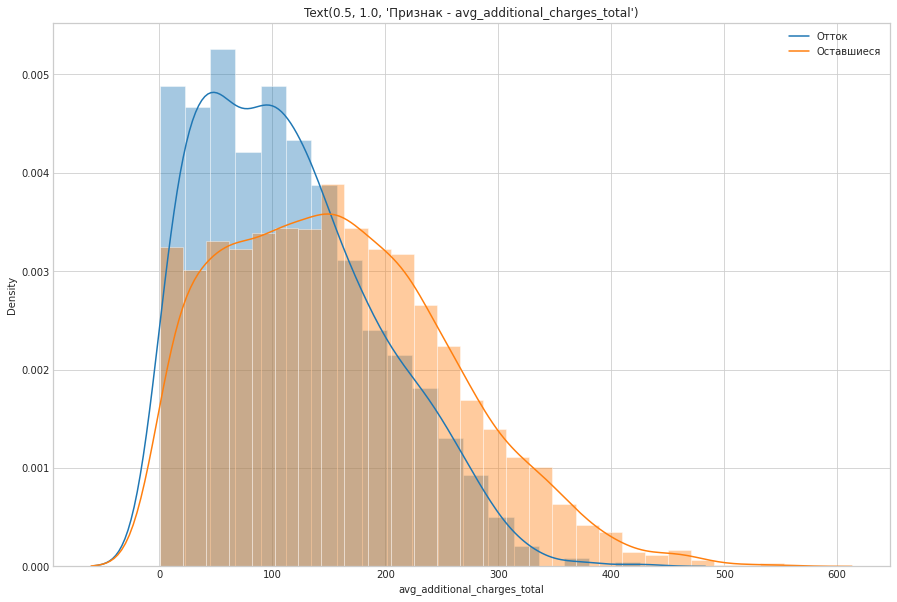

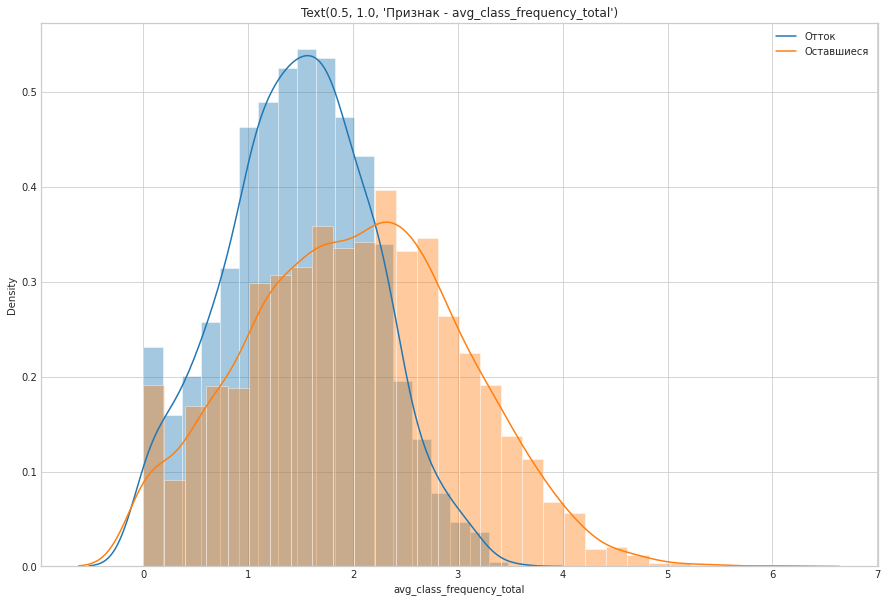

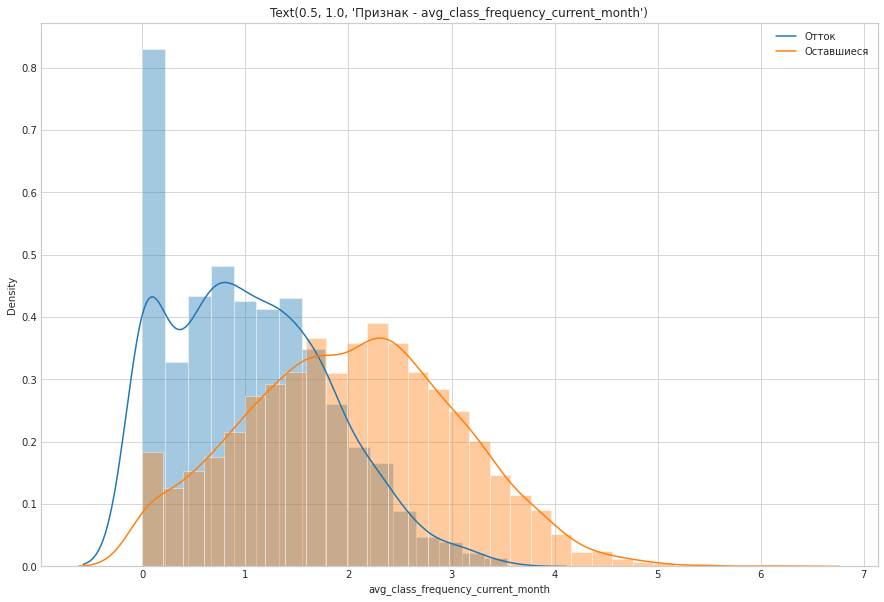

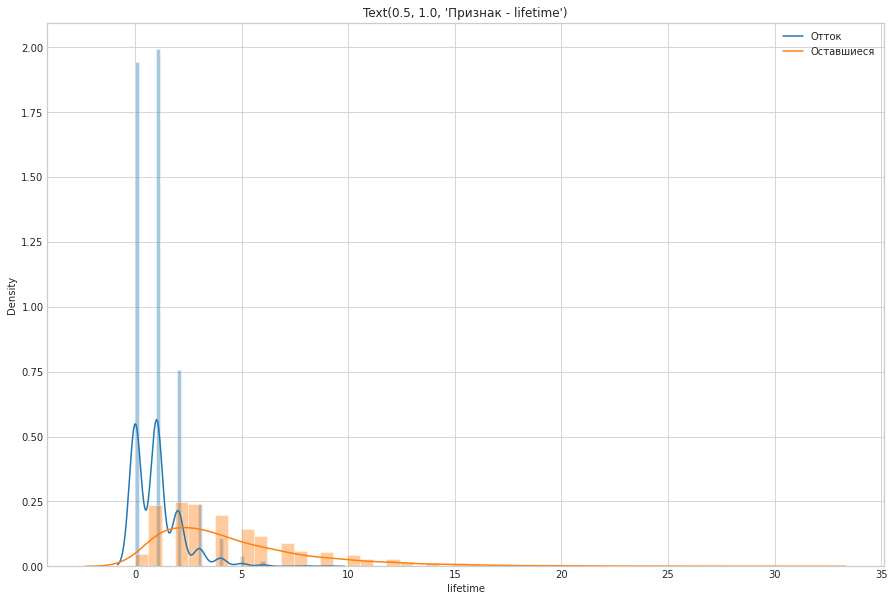

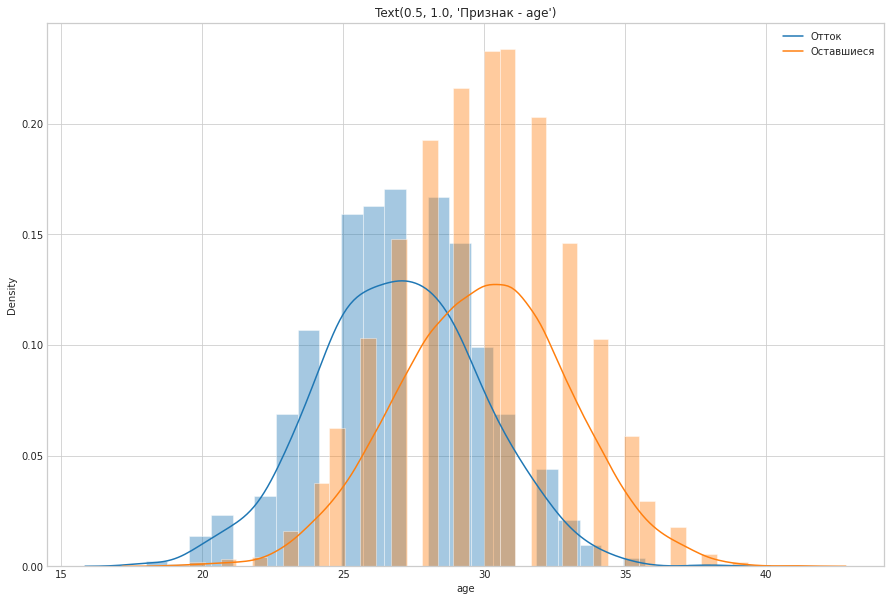

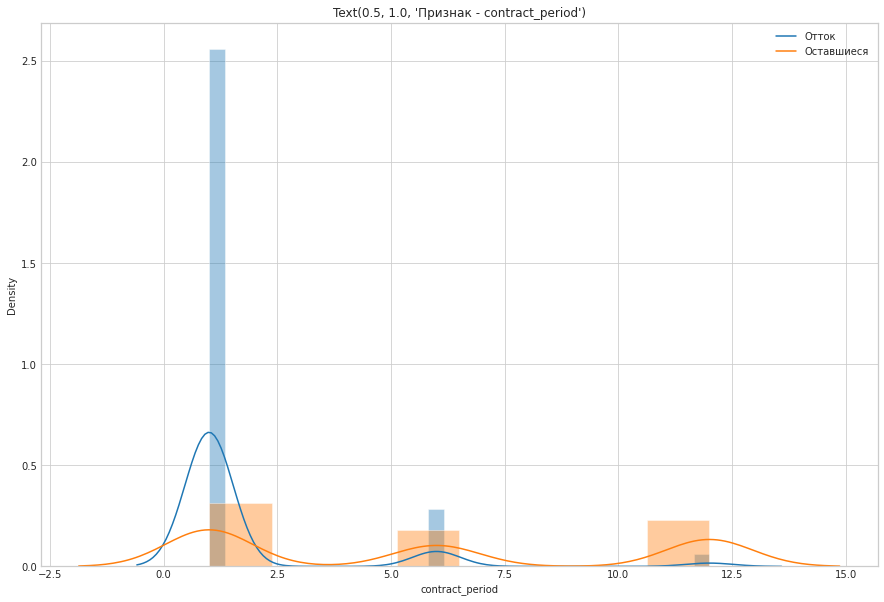

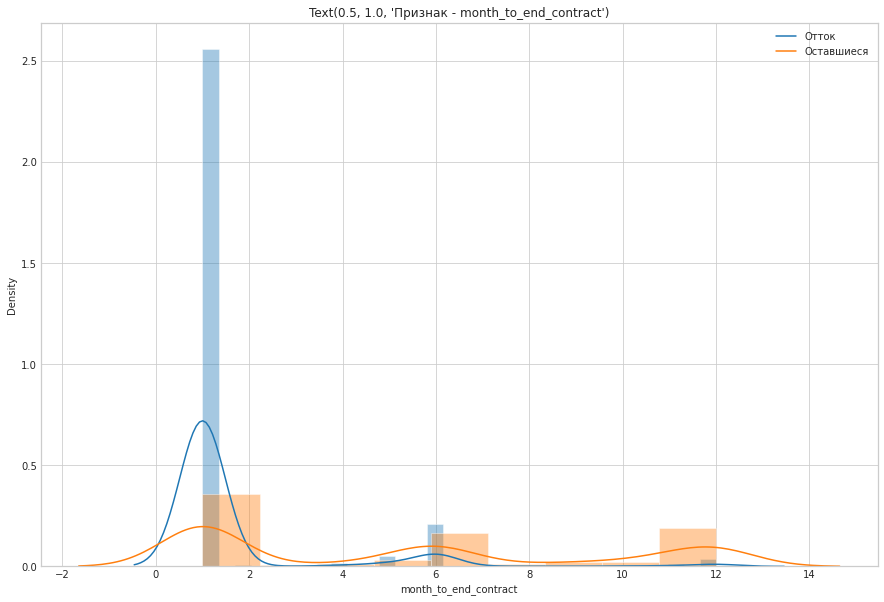

In [9]:
outflow = df.loc[df['churn']==1]
residuary = df.loc[df['churn']==0]
columns = ['avg_additional_charges_total',
           'avg_class_frequency_total',
           'avg_class_frequency_current_month',
           'lifetime',
           'age',
           'contract_period', 'month_to_end_contract']

for column in columns: 
  plt.figure(figsize=(15,10)) 
  plt.title(plt.title(f'Признак - {column}'))
  sns.distplot(outflow[column])
  sns.distplot(residuary[column])
  plt.legend(['Отток', 'Оставшиеся'])
  plt.show();

- `Суммарная выручка от других услуг фитнес-центра`: Данный показатель, не влияет на отток, а является его следствием.


- `Средняя частота посещений в неделю за все время с начала действия абонемента`: Клиенты, занимающиеся меньше 2 раз в неделю чаще теряют интерес к тренировкам, чем люди, занимающиеся полноценно.


- `Средняя частота посещений в неделю за предыдущий месяц`: 


- `Время с момента первого обращения`:  Люди, отзанимавшиеся 2+ месяца практически не попадают в отток.


- `Возраст`: Люди, ближе к 30 годам более активнее начинают заботиться о здоровье и не бросают тренировки.


-  `Длительность текущего действующего абонемента` и `Срок до окончания текущего действующего абонемента`: Люди, с близким окончанием абонемента в фитнес-центр очень часто попадают в отток.

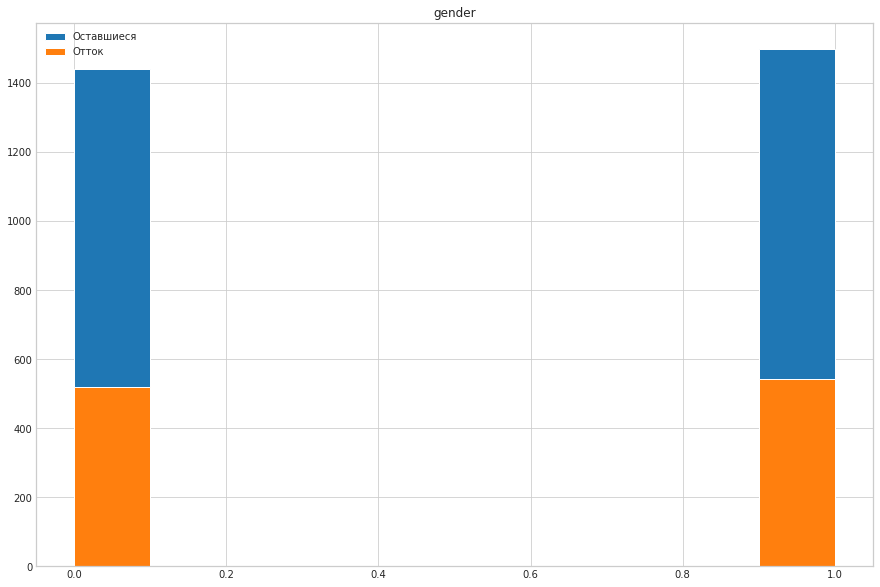

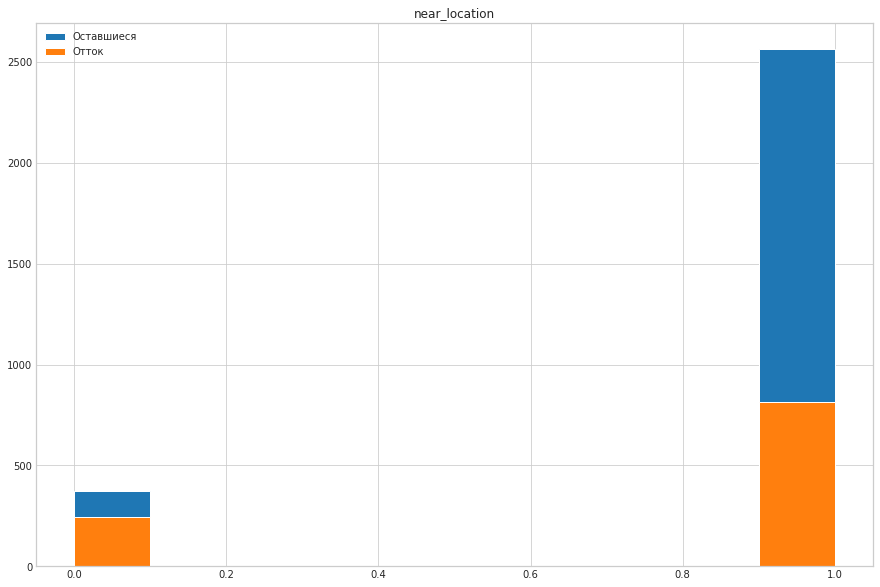

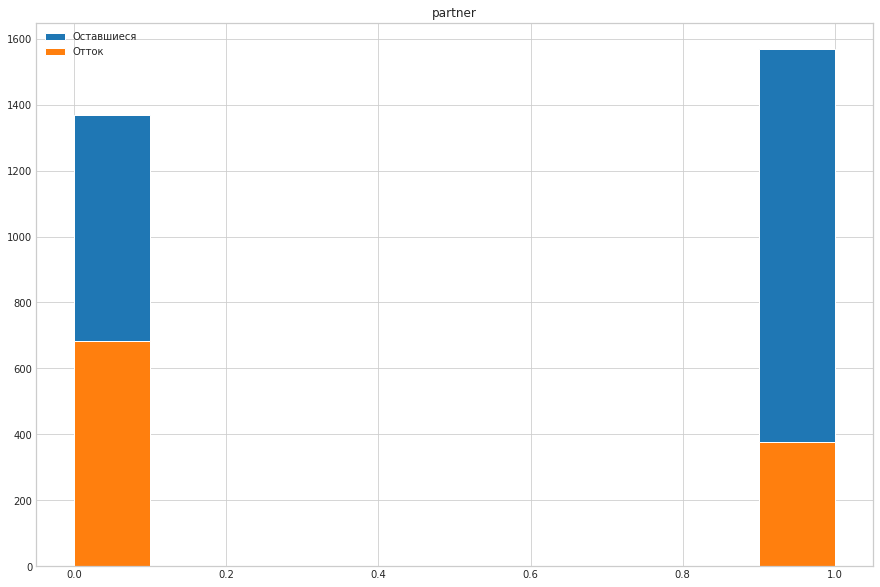

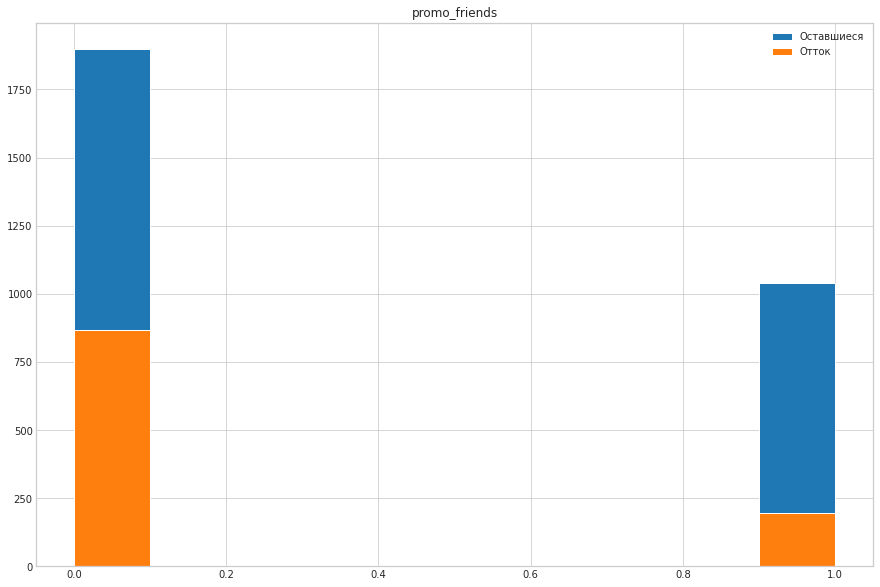

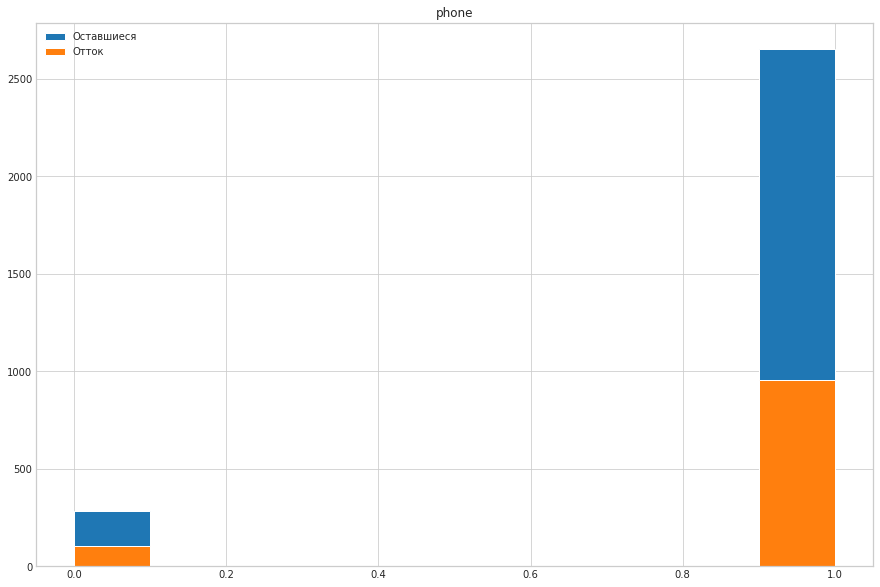

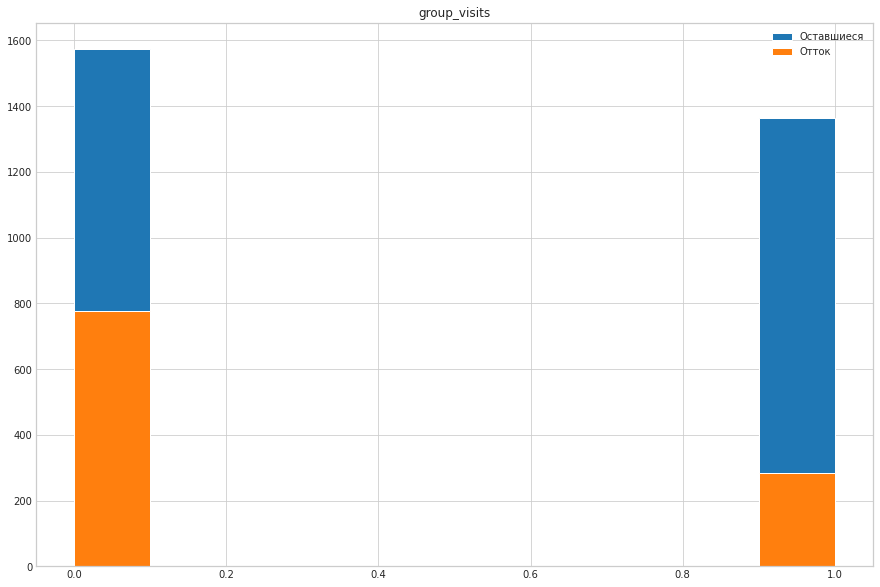

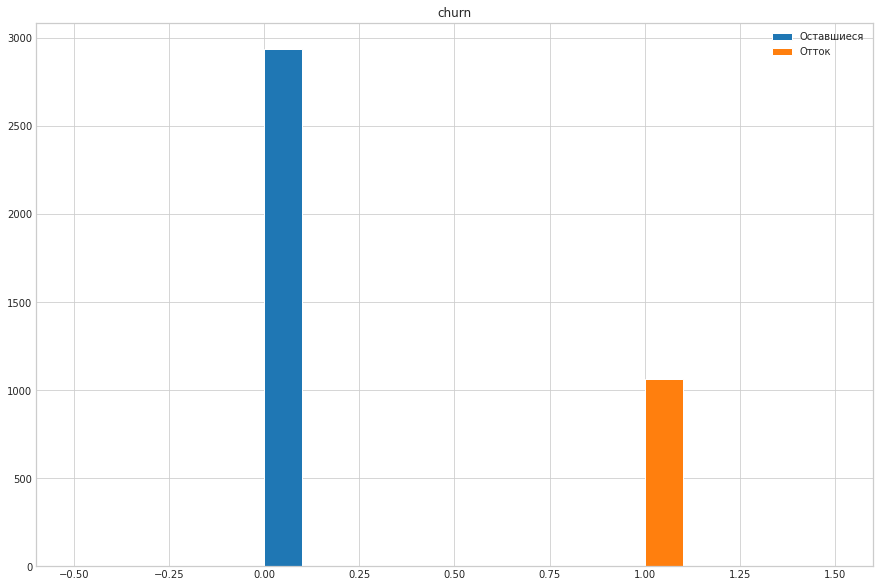

In [10]:
for column in df.columns:
  if column not in columns:
    plt.figure(figsize=(15,10))
    df.groupby('churn')[column].hist()
    plt.title(column)
    plt.legend(['Оставшиеся', 'Отток'])
    plt.show();

- `Пол`: Отток одинаково присущ, как женщинам, так и мужчинам.


- `Проживание/работа в районе, где находится фитнес-центр`: Клиенты прощивающие далеко от фитнес-центра в большей степени привержены к оттоку.


- `Сотрудник компании-партнёра клуба`: Партнеры фитнес-центра в меньшей степени перестают ходить в зал, обычные пользователи услугой фитнес-зала практически в половине случаев попадают в отток.


- `Факт первоначальной записи в рамках акции «приведи друга»`: Участников промо-акции меньше, но доля оставшихся среди них значительно больше.


- `Наличие контактного телефона`: Практически все оставили контактный номер, на отток данный признак никак не влияет.


- `Факт посещения групповых занятий`: Групповые занятия стимулируют пользователей ходить на тренировки и не бросать их.

**Построим матрицу корреляций распределения признаков.**

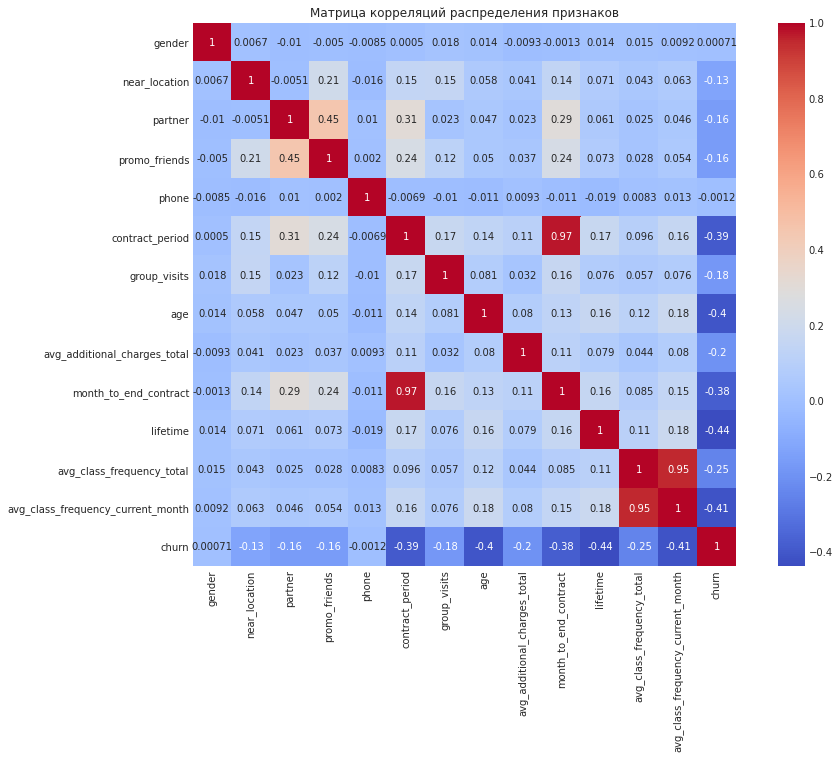

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(data = df.corr(), annot=True, square=True, cmap='coolwarm')
plt.title('Матрица корреляций распределения признаков')
plt.show();

- Есть 2 мультиколлинеарных признака: `contract_period` и `month_to_end_contact`.
- Пол и наличие контактного номера никаким образом не влияют на отток.
- В целом нет заметных признаков, влияющих на отток.

# **Постройте модель прогнозирования оттока клиентов**

In [12]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 
display(X_train_st[:5])

X_test_st = scaler.transform(X_test) 

array([[-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         1.60502986, -0.84769226,  0.57944798,  0.37161711,  1.59173796,
         1.12734972,  1.75580418,  1.61822807],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125,  0.31628211,
        -0.81299073, -0.84769226,  0.27046055, -1.09697378, -0.79568246,
         5.88138322, -0.2239674 , -0.01340886],
       [ 0.98511083,  0.4175068 ,  1.03175391, -0.67567125,  0.31628211,
         1.60502986, -0.84769226, -0.65650171, -1.18374157,  1.83048   ,
         0.3350108 , -0.84308456, -0.80541199],
       [-1.01511421,  0.4175068 ,  1.03175391,  1.4800097 ,  0.31628211,
         0.28610954, -0.84769226, -0.96548914, -0.95158829,  0.39802775,
         1.39146269,  0.66771379,  0.64605224],
       [-1.01511421,  0.4175068 , -0.96922337, -0.67567125, -3.16173427,
        -0.81299073, -0.84769226, -0.03852687,  0.97190435, -0.79568246,
         0.07089783, -0.19587934, -0.16038147]])

In [13]:
def metrics(name, mdl):
    mdl.fit(X_train_st, y_train)
    y_pred = mdl.predict(X_test_st)
    print("Модель прогнозирования", name)
    
    

    acc = accuracy_score(y_test, y_pred)
    print("Доля правильных ответов: Accuracy =",acc.round(2))
    precision = precision_score(y_test, y_pred).round(2)
    print("Точность: precision =", precision)
    recall = recall_score(y_test, y_pred).round(2)
    print("Полнота: recall =", recall, '\n')

In [14]:
model = LogisticRegression(random_state=0)
metrics('"Логистическая регрессия"', model)

Модель прогнозирования "Логистическая регрессия"
Доля правильных ответов: Accuracy = 0.92
Точность: precision = 0.85
Полнота: recall = 0.83 



In [15]:
model = RandomForestClassifier(n_estimators = 100, random_state=0)
metrics('"Случайный лес"', model)

Модель прогнозирования "Случайный лес"
Доля правильных ответов: Accuracy = 0.92
Точность: precision = 0.84
Полнота: recall = 0.81 



- Логическая регрессия оказалась успешнее Случайного леса. Accuracy показали себя одинаково, но Precision логической регрессия показал себя лучше 0.85 против 0.84, а Recall 0.83 против 0.81

# **Кластеризация данных**

## Стандартизация данные.

In [16]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc[:5]

array([[ 0.97970588,  0.42788074,  1.02686062,  1.49716101, -3.05985201,
         0.28989014,  1.19403206, -0.0565538 , -1.37753121,  0.16160501,
        -0.19332863, -1.91191971, -1.67847198],
       [-1.0207145 ,  0.42788074, -0.973842  , -0.66793083,  0.32681319,
         1.60882159,  1.19403206,  0.55732732, -0.35021325,  1.83194105,
         0.87368001,  0.04517569,  0.1360137 ],
       [-1.0207145 ,  0.42788074,  1.02686062, -0.66793083,  0.32681319,
        -0.8092194 , -0.83749845, -0.36349436, -0.1815923 , -0.79287273,
        -0.46008079, -0.02049263, -0.02901851],
       [-1.0207145 ,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
         1.60882159,  1.19403206,  1.17120844, -0.87472237,  1.83194105,
        -0.46008079,  1.36465509,  1.51045005],
       [ 0.97970588,  0.42788074,  1.02686062,  1.49716101,  0.32681319,
        -0.8092194 , -0.83749845, -0.97737548,  0.5336998 , -0.79287273,
        -0.19332863, -0.78707638, -0.61454183]])

## Матрица расстояний функцией linkage(). Нарисуем дендрограмму.

In [17]:
link = linkage(X_sc, method = 'ward')
link

array([[9.70000000e+01, 3.22200000e+03, 1.00990653e-01, 2.00000000e+00],
       [2.61000000e+02, 3.17900000e+03, 1.22634574e-01, 2.00000000e+00],
       [8.90000000e+02, 1.75000000e+03, 1.28123291e-01, 2.00000000e+00],
       ...,
       [7.98700000e+03, 7.99500000e+03, 8.38725499e+01, 2.65600000e+03],
       [7.98800000e+03, 7.99600000e+03, 8.89563592e+01, 3.03400000e+03],
       [7.99200000e+03, 7.99700000e+03, 1.04627601e+02, 4.00000000e+03]])

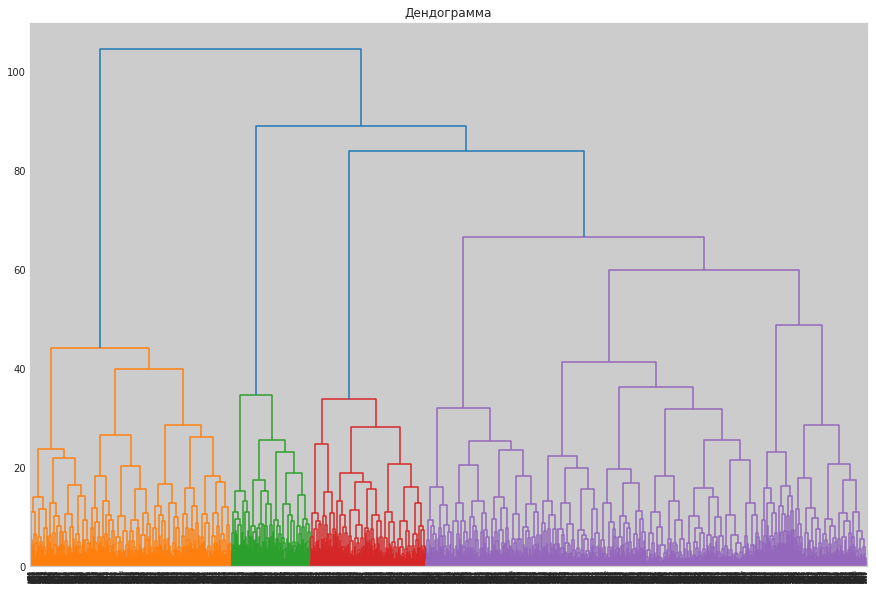

In [18]:
plt.figure(figsize=(15, 10))  
dendrogram(link)
plt.title('Дендограмма')
plt.show()

- Из данной дендограммы можно выделить 6 основных групп, в дальнейшем будем использовать 5, согласно ТЗ./

## Обучение модели кластерищации на основании алгоритма K-Means

- Принимаем число кластеров - 5 и применим алгоритм K-Means
- В переменной labels сохраняются индексы предложенных алгоритмом групп.

In [19]:
km = KMeans(n_clusters = 5, random_state=0) 
labels = km.fit_predict(X_sc)
labels
df['km_clusters'] = labels
df

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,km_clusters
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0,1
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0,3
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0,0
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29,1,3
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0,0
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60,0,0


## Средние значения признаков для кластеров.

In [20]:
df.groupby('km_clusters').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
km_clusters,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


**Кластер 0 :**
- Практически все клиенты живут поблизости зала.
- 78% - партнеры, также 57% пришли от друзей-клиентов спортзала.
- Самый низкий Отток - 3%


**Кластер 1 :**
- 86% клиентов живут поблизости зала.
- 47% - партнеры, также 31% пришли от друзей-клиентов спортзала.
- Отток составляет - 27%


**Кластер 2 :**
- Данных по местоположению к залу нет, либо все живут очень далеко.
- 46% - партнеры, также 8% пришли от друзей-клиентов спортзала.
- Отток составляет целых 44%


**Кластер 3 :**
- Все клиенты живут поблизости зала.
- 35% - партнеры, также 24% пришли от друзей-клиентов спортзала.
- Самый высокий Отток - 51%


**Кластер 4 :**
- Практически все клиенты живут поблизости зала.
- 36% - партнеры, также 23% пришли от друзей-клиентов спортзала.
- Низкий Отток - 7%


- Все Кластеры имеют практически ровные доли гендерного признака
- Также стоит отметить, что кластеры с низким оттоком приносят больше суммарной выручки от других услуг фитнес-центра
- Клиенты кластера 0 с самой низким значением оттока имеют самые "длинные" абонементы - в среднем 10 месяцев.
- Клиенты кластера 2 и 3, имеют меньшую ступень посещения спортзала(недельную, месячную)

## Распределение признаков для кластеров.

In [21]:
first_mean = df[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits']]
second_mean = df[['age','contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']]

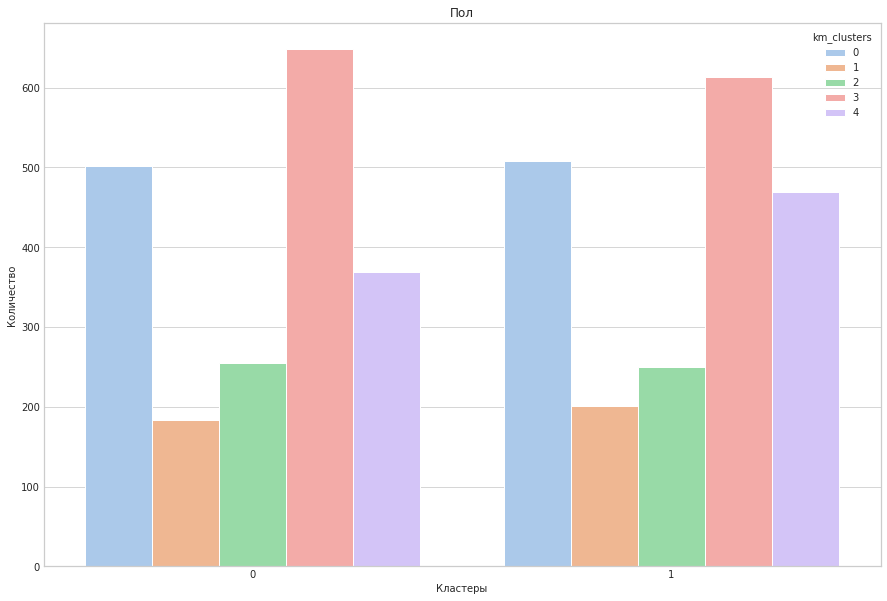

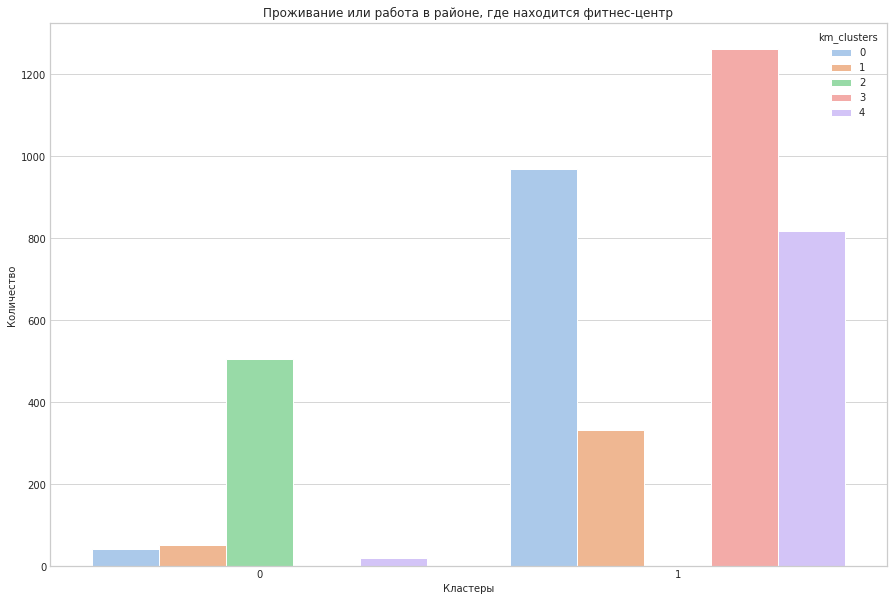

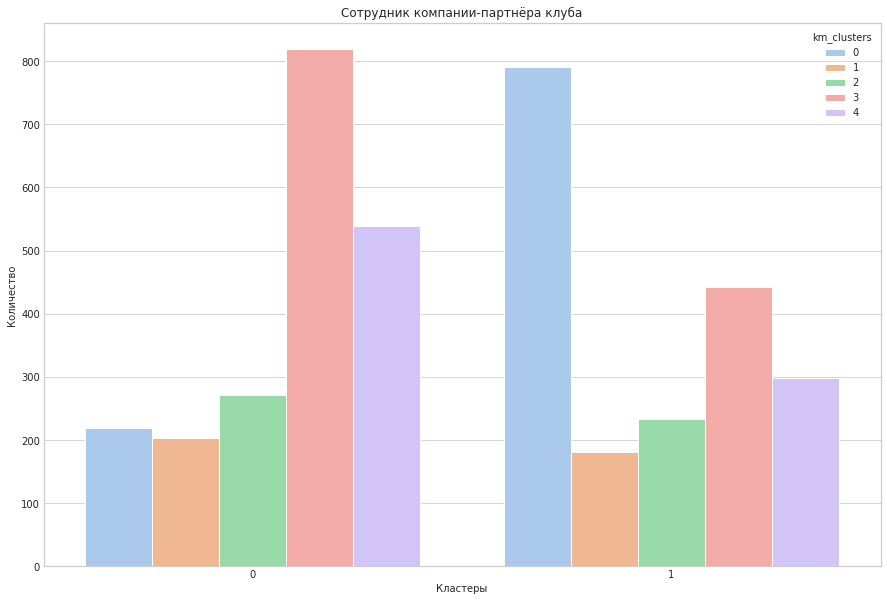

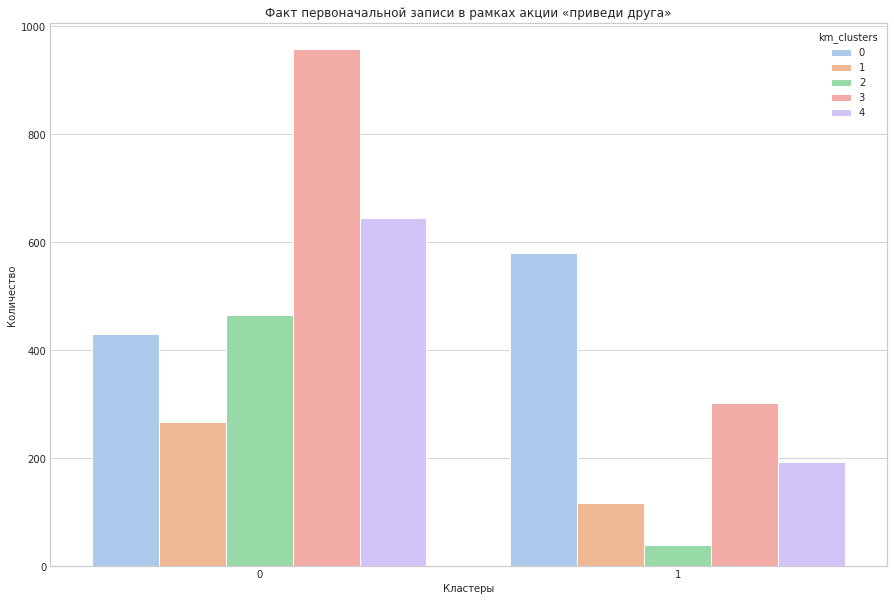

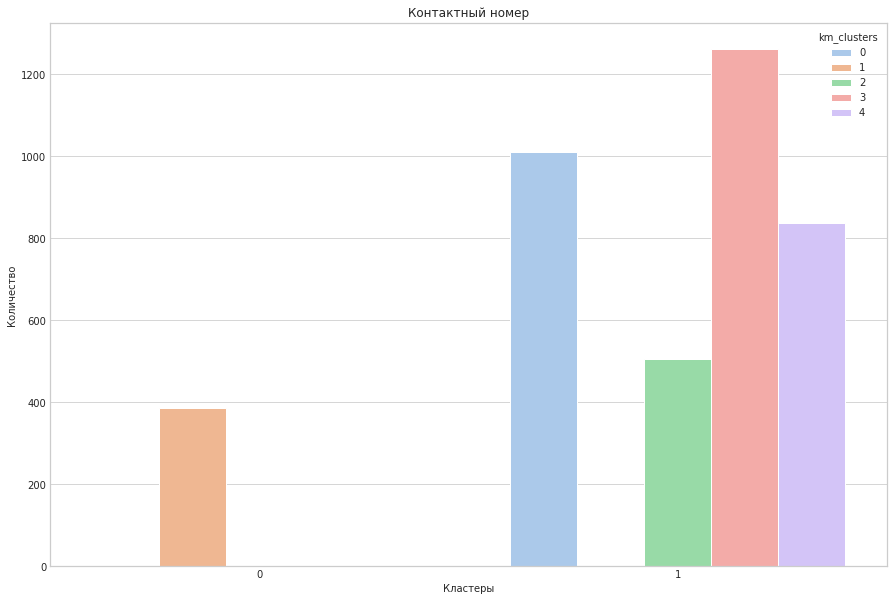

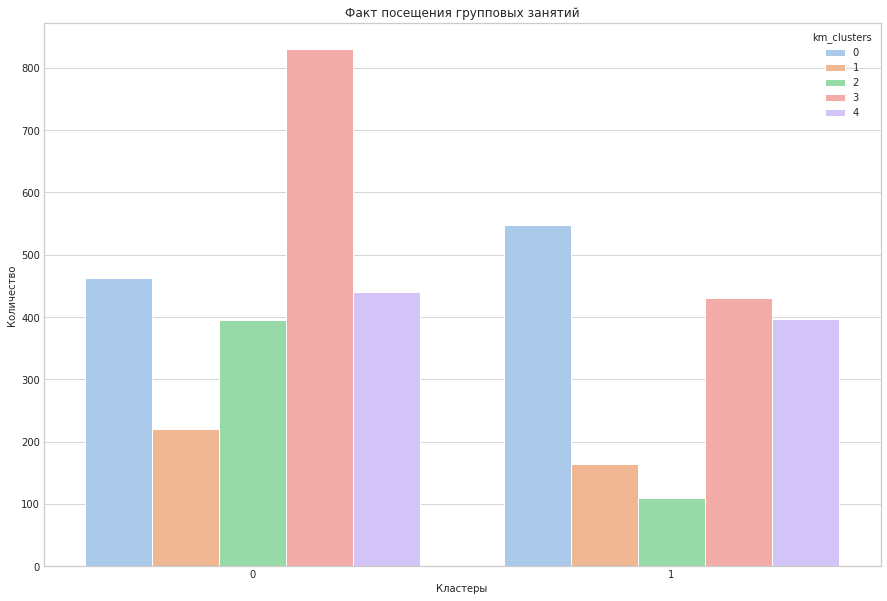

In [22]:
countplt, ax = plt.subplots(figsize = (15,10))
ax =sns.countplot(x = 'gender', data=df, palette='pastel', hue='km_clusters')
plt.title('Пол')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show()

countplt, ax = plt.subplots(figsize = (15,10))
ax =sns.countplot(x = 'near_location', data=df, palette='pastel', hue='km_clusters')
plt.title('Проживание или работа в районе, где находится фитнес-центр')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show()

countplt, ax = plt.subplots(figsize = (15,10))
ax =sns.countplot(x = 'partner', data=df, palette='pastel', hue='km_clusters')
plt.title('Сотрудник компании-партнёра клуба')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show()

countplt, ax = plt.subplots(figsize = (15,10))
ax =sns.countplot(x = 'promo_friends', data=df, palette='pastel', hue='km_clusters')
plt.title('Факт первоначальной записи в рамках акции «приведи друга»')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show()

countplt, ax = plt.subplots(figsize = (15,10))
ax =sns.countplot(x = 'phone', data=df, palette='pastel', hue='km_clusters')
plt.title('Контактный номер')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show()

countplt, ax = plt.subplots(figsize = (15,10))
ax =sns.countplot(x = 'group_visits', data=df, palette='pastel', hue='km_clusters')
plt.title('Факт посещения групповых занятий')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show()

- `Пол`: Все кластеры одинаково распределены по полу, внутри кластеров также заметно, что спортзал посещают одинаково мужчины и женщины.


- `Проживание/работа в районе, где находится фитнес-центр`: Кластер2 выделяется на общем фоне, очень большое количество клиентов живут отдаеленно от зала.


- `Сотрудник компании-партнёра клуба`: Кластер 0 и 4 являются партнерами клуба, а кластеры 1 и 3 не сотрудничают со спортивным залом.


- `Факт первоначальной записи в рамках акции «приведи друга»`: 1 и 3 при сотрудничестве используют все привелегии акции, 0 и 4 нет


- `Наличие контактного телефона`: Кластер1 не стал указывать контактный телефон, либо же в данных произошла ошибка, т.к. при регистрации в спортивный зал, обычно указываются контактные данные.


- `Факт посещения групповых занятий`: Кластер1 и 3, не являясь партнерами спортивного клуба предпочитают одиночные тренировки, в то время как Кластеры 0 и 4 любят проводить время со своими коллегами в спортзале.

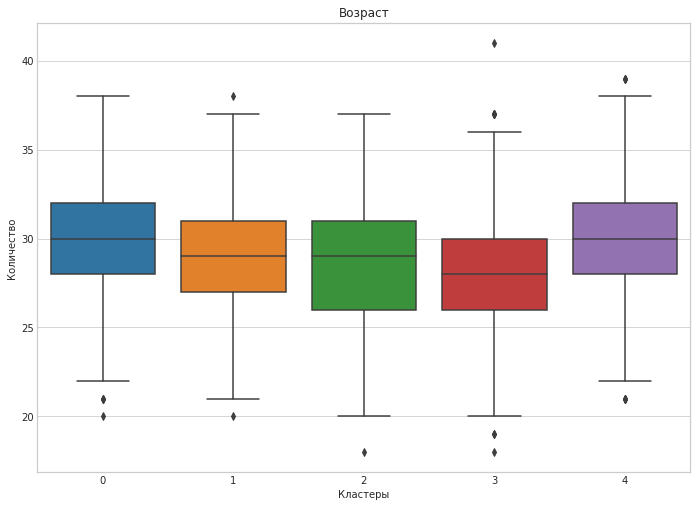

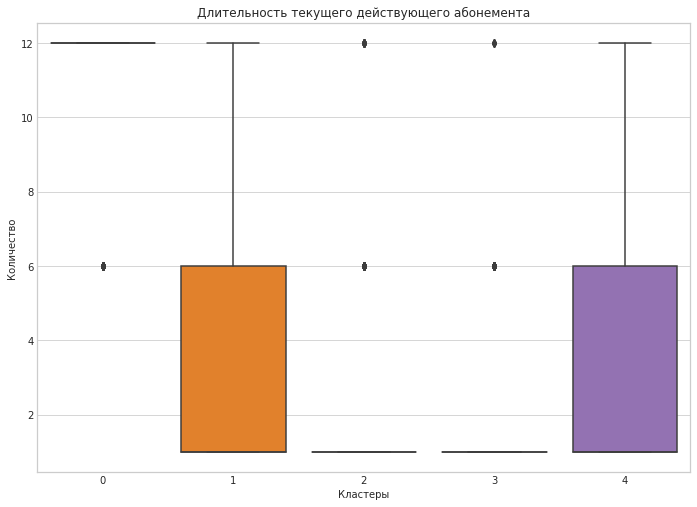

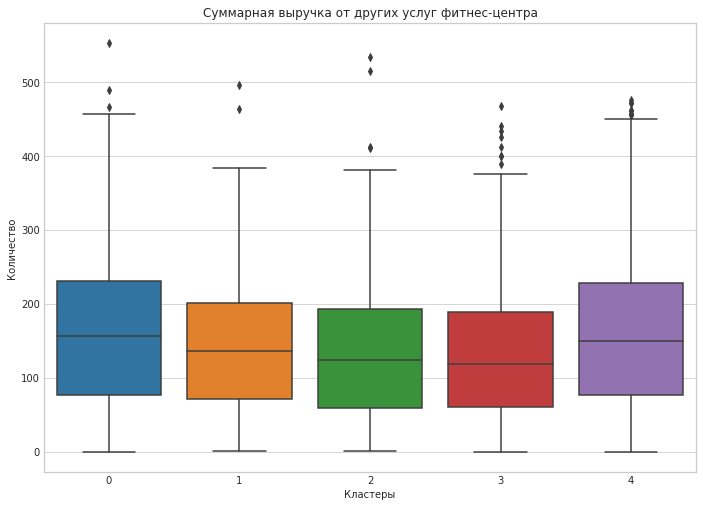

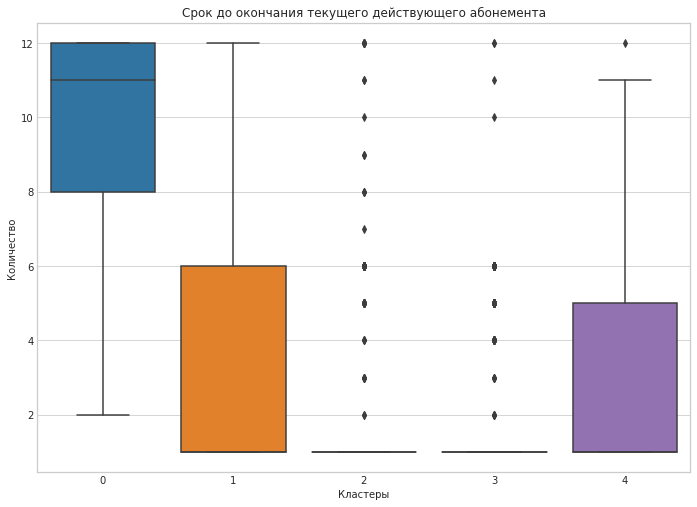

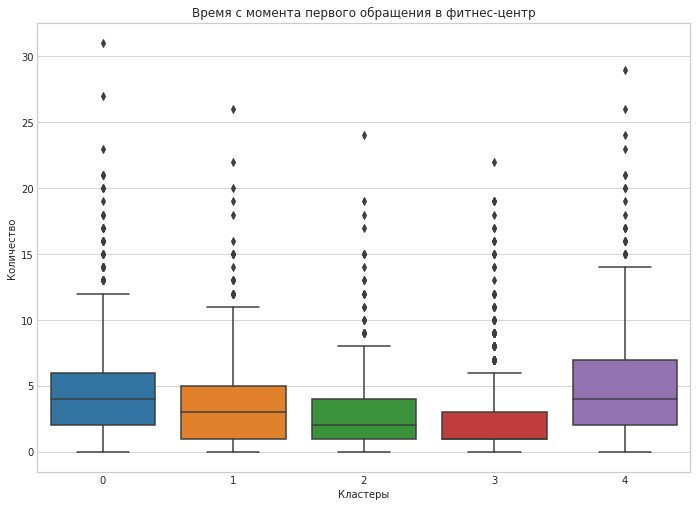

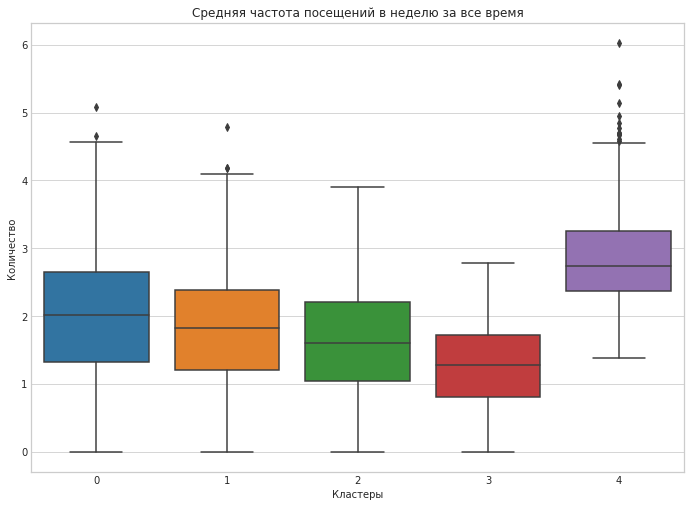

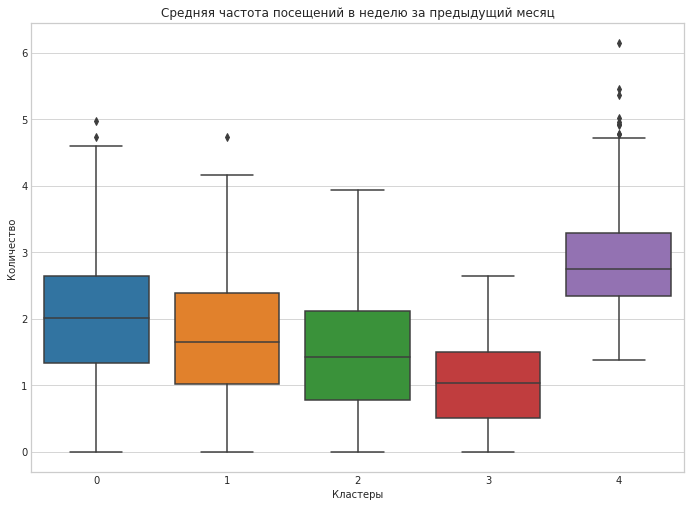

In [23]:
rcParams['figure.figsize'] = 11.7,8.27
sns.boxplot(data=df, x='km_clusters', y='age')
plt.title('Возраст')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show();

sns.boxplot(data=df, x='km_clusters', y='contract_period')
plt.title('Длительность текущего действующего абонемента')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show();

sns.boxplot(data=df, x='km_clusters', y='avg_additional_charges_total')
plt.title('Суммарная выручка от других услуг фитнес-центра')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show();

sns.boxplot(data=df, x='km_clusters', y='month_to_end_contract')
plt.title('Срок до окончания текущего действующего абонемента')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show();

sns.boxplot(data=df, x='km_clusters', y='lifetime')
plt.title('Время с момента первого обращения в фитнес-центр')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show();

sns.boxplot(data=df, x='km_clusters', y='avg_class_frequency_total')
plt.title('Средняя частота посещений в неделю за все время')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show();

sns.boxplot(data=df, x='km_clusters', y='avg_class_frequency_current_month')
plt.title('Средняя частота посещений в неделю за предыдущий месяц')
plt.xlabel('Кластеры')
plt.ylabel('Количество')
plt.show();



- `Возраст`: в кластере3 преобладают клиенты до 30 лет, в то время как в Кластере0 - преобладают клиенты за 30 лет


- `Длительность текущего действующего абонемента`: Видно что абонементы есть на 1,6,12 месяцев, в кластере0 преобладают годовые абонементы, в этом и может  скрываться самый низкий отток, Кластер3 с самым высоким оттоком имеет клиентов преобладающих месячным абонементом.


- `Суммарная выручка от других услуг фитнес-центра`:Также кластер3 приносит меньшую вырочку от других услуг фитнес-центра, при большом оттоке клиенты не задерживаются в самом спортивном зале, не говоря уже об использовании других возможностей, а клиенты с годовыми абонементами с удовольствием пользуются сервисом фитнес-центра.


- `Срок до окончания текущего действующего абонемента`: Кластер0 имеет больший срок окончания действующего абонемента, очень много клиентов с годовым абонементом, но пользующимися им только месяц, возможно поэтому отток на таком маленьком уровне.


- `Время с момента первого обращения`: Кластер3 с преимущественно месячными абонементами имеют меньшое время обращения с момента прихода в фитнес-центр, а в Кластере0 преимущественно люди, которые занимаются 2+ месяца.


- `Средняя частота посещений в неделю за все время с начала действия абонемента` и `Средняя частота посещений в неделю за предыдущий месяц`: Клиенты из Кластер3 ходят в зал в среднем 1 раз в неделю, в то время как Кластер0 - в среднем 2 раза.

## Доля оттока кластеров.

In [38]:
outflow_parts  = ((df.groupby('km_clusters')['churn'].mean()) * 100).reset_index()
outflow_parts

,km_clusters,churn
0,0,2.77
1,1,26.75
2,2,44.36
3,3,51.43
4,4,6.80


- **Кластер0**: отток - `2.77%`
- Клиенты, проживающие поблизости с залом, в основной массе с годовыми абонементами, в большей степени приобретенные по партнер-программе. - Надежная группа, которая также приносит большую прибыль фитнес-клубу за доп. услуги.


- **Кластер1**: отток -  `26.75%`
- Клиенты без контактного номера, проживающие в основном по близости фитнес-центра, владеющие очень маленькими абонементами, но при этом достаточно часто посещающие его, недостаточно надежная группа, но все же клиенты данного кластера могут быть разбросаны и по другим кластерам без потери качества.


- **Кластер2**: отток -  `44.36%`
- Клиенты, в основном проживающие далеко от зала, среднее посещение низкой, поэтому и отток на достаточно высоком уровне.


- **Кластер3**: отток -  `51.53%`
- Полный антипод Кластеру0, не являются парнерами, предпочитают месячные абонементы, не используют дополнительный сервис. Имеет огромный отток, на данный кластер следует обратить внимание, а именно сроку продаваемых абонементов, ввод акций для данной группы, а также популяризация групповых тренировок.


- **Кластер4**: отток -  `6.80%`
- Клиенты, являются партнерами фитнес-центра и предпочитают групповые тренировки из-за чего отток крайне низок. 

# **Вывод**

- При анализе данных заметили 2 мультиколлинеарных признака: `contract_period` и `month_to_end_contact`, но в  целом нет заметных признаков, влияющих на отток.
- Логическая регрессия оказалась успешнее Случайного леса. Accuracy показали себя одинаково, но Precision логической регрессия показал себя лучше 0.85 против 0.84, а Recall 0.83 против 0.81.


**- Согласно ТЗ,обучили модель кластеризации и оставили 5 моделей.**
- **Кластер0**: отток - `2.77%`
- Клиенты, проживающие поблизости с залом, в основной массе с годовыми абонементами, в большей степени приобретенные по партнер-программе. - Надежная группа, которая также приносит большую прибыль фитнес-клубу за доп. услуги.


- **Кластер1**: отток -  `26.75%`
- Клиенты без контактного номера, проживающие в основном по близости фитнес-центра, владеющие очень маленькими абонементами, но при этом достаточно часто посещающие его, достаточно надежная группа, но все же клиенты данного кластера могут быть разбросаны и по другим кластерам без потери качества.


- **Кластер2**: отток -  `44.36%`
- Клиенты, в основном проживающие далеко от зала, среднее посещение низкой, поэтому и отток на достаточно высоком уровне.


- **Кластер3**: отток -  `51.53%`
- Полный антипод Кластеру0, не являются парнерами, предпочитают месячные абонементы, не используют дополнительный сервис. Имеет огромный отток, на данный кластер следует обратить внимание, а именно сроку продаваемых абонементов, ввод акций для данной группы, а также популяризация групповых тренировок.


- **Кластер4**: отток -  `6.80%`
- Клиенты, являются партнерами фитнес-центра и предпочитают групповые тренировки из-за чего отток крайне низок. 

- Все Кластеры имеют практически ровные доли гендерного признака
- Также стоит отметить, что кластеры с низким оттоком приносят больше суммарной выручки от других услуг фитнес-центра
- Клиенты кластера 0 с самой низким значением оттока имеют самые "длинные" абонементы - в среднем 10 месяцев.
- Клиенты кластера 2 и 3, имеют меньшую ступень посещения спортзала(недельную, месячную)


**Базовые рекомендации по работе с клиентами:**
1. Одна из самых проблемных клиентов - клиенты, которые берут маленькие абонементы, доля оттока крайне высока. Необходимо привлекать данных клиентов акциями и скидками на абонементы, более длительного срока, чтобы данная группа не думала бросать тренировки.
2. К оттоку привержены клиенты, не посещающие групповые тренировки, необходимо рассказывать и предлагать клиентам данные услуги, потому что многие склоны просто стесняться незнакомых людей.
3. Стимулировать клиентов посещать фитнес-центр чаще раза в неделю, с помощью каких-либо промоакций.
